In [47]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
from functions import plots
from functions import finite_volumes as fv
from functions import finite_volumes_split as fvs
from functions import finite_volumes_par as fvp
from functions import neural_network as nn
import mnist

# IMAGE INPAINTING WITH FLUID DYNAMICS

Image inpainting aims to remove damage from an image. There are various techniques for image inpainting, and here we focus on solving a fluid-type PDE denoted as the Cahn-Hilliard equation.

The three take-home messages from this notebook are that:

1. Image inpainting can be solved with efficient and parallelizable finite-volume schemes
2. The classification accuracy of neural networks is affected by the presence of damage 
3. The application of image inpainting in damaged images improves their classification accuracy

<p>&nbsp;</p>

#### Damaged image:
<img src="images/damage_23.png" style="width:300px;height:250px;" >

#### Restored image:
<img src="images/inpainting_23.png" style="width:300px;height:250px;" >

As an example we take the MNIST dataset, which consists of binary images of handwritten digits:

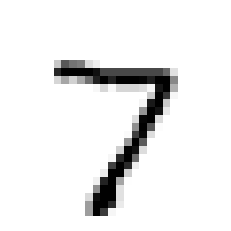

In [48]:
test_images = mnist.test_images() # Load MNIST test set
test_images = test_images.reshape((-1,784)) # Flatten
test_images = (test_images / 255) *2-1 # Normalize between -1 and 1
example = test_images[0,:] # Select 1 image
plots.plot_image(example) # Plot image

The MNIST dataset is corrupted by adding different types of damage to it:

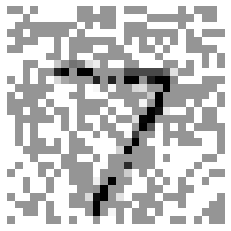

In [49]:
intensity = 0.5 # elect % of damaged pixels

damage = np.random.choice(np.arange(example.size), replace=False, 
                          size=int(example.size * intensity)) # Create random damage
damaged_example = example.copy() # Generate damaged example
damaged_example[damage] = 0 # Turn damaged pixels to 0
plots.plot_image(damaged_example) # Plot image

## Finite volumes for image inpainting

With image inpainting we aim to recover the original image. There are various methods to conduct image inpainting, and here I solve a modified Cahn-Hilliard equation via finite-volume schemes:


$$
\frac{\partial \phi (x,t)}{\partial t}= -\nabla^{2} \left(\epsilon^2 \nabla^{2} \phi -  H'(\phi) \right) + \lambda(x)\left(\phi (x,t=0) - \phi\right)
$$

As a baseline let's solve this equation with a simple finite-volume scheme:

--------------------
Time:  0.0
['L1 norm of the difference between the new and old state: ', 293.5527206136236]
--------------------
Time:  0.1
['L1 norm of the difference between the new and old state: ', 70.80765875785028]
--------------------
Time:  0.2
['L1 norm of the difference between the new and old state: ', 29.013627612885912]
--------------------
Time:  0.30000000000000004
['L1 norm of the difference between the new and old state: ', 11.724573659317787]
--------------------
Time:  0.4
['L1 norm of the difference between the new and old state: ', 5.837640815931027]
--------------------
Time:  0.5
['L1 norm of the difference between the new and old state: ', 2.8892061603180688]
--------------------
Time:  0.6
['L1 norm of the difference between the new and old state: ', 1.6380886623751225]
--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 0.9633544505193916]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference 

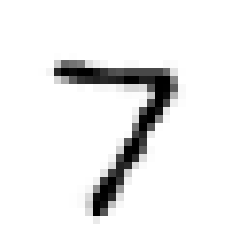

In [50]:
start = time.time() # Start time
restored_example = fv.temporal_loop(damaged_example, damage) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

Let's compare the restored image with respect to the original image:


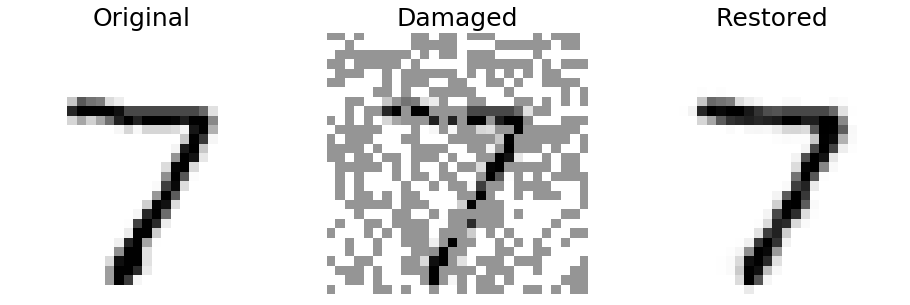

In [51]:
plots.plot_3images(example, damaged_example, restored_example)  # Plot 3 images

The computational cost of finite-volume scheme can be reduced by:

1. Applying a dimensional-splitting technique and solving row by row and column by column
2. Parallelizing the code and solving rows/columns simultaneously

The simple finite-volume scheme has taken 40s to run. Let's compare it with the dimensional-splitting code:fully parallelized code:

--------------------
Time:  0.0
['L1 norm of the difference between the new and old state: ', 262.0339086632083]
--------------------
Time:  0.1
['L1 norm of the difference between the new and old state: ', 58.06955572215037]
--------------------
Time:  0.2
['L1 norm of the difference between the new and old state: ', 22.048729656053148]
--------------------
Time:  0.30000000000000004
['L1 norm of the difference between the new and old state: ', 9.789847177849662]
--------------------
Time:  0.4
['L1 norm of the difference between the new and old state: ', 4.825914027673576]
--------------------
Time:  0.5
['L1 norm of the difference between the new and old state: ', 2.592470093879773]
--------------------
Time:  0.6
['L1 norm of the difference between the new and old state: ', 1.489734930859102]
--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 0.9160257254952464]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference bet

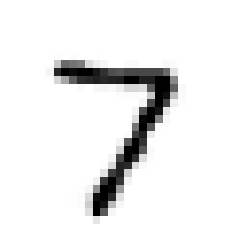

In [52]:
start = time.time() # Start time
restored_example = fvs.temporal_loop_split(damaged_example, damage) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

By dimensionally splitting the code we have reduced the computational time from 40s to 8s!

Can we reduce that time by parallelizing?

--------------------
Time:  0.0
['L1 norm of the difference between the new and old state: ', 262.42842549085543]
--------------------
Time:  0.1
['L1 norm of the difference between the new and old state: ', 56.71599373578927]
--------------------
Time:  0.2
['L1 norm of the difference between the new and old state: ', 21.793754162627046]
--------------------
Time:  0.30000000000000004
['L1 norm of the difference between the new and old state: ', 9.818795483300335]
--------------------
Time:  0.4
['L1 norm of the difference between the new and old state: ', 4.849590210655972]
--------------------
Time:  0.5
['L1 norm of the difference between the new and old state: ', 2.5932277591482533]
--------------------
Time:  0.6
['L1 norm of the difference between the new and old state: ', 1.4909819342148425]
--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 0.9169305811075479]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference 

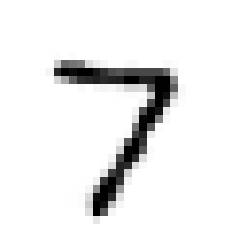

In [53]:
num_proc = 8 # Number of processors
start = time.time() # Start time
restored_example = fvp.temporal_loop_par(damaged_example, damage, num_proc) # Run finite-volume scheme
print("Total time: {:.2f}".format(time.time()-start)) # Print spent time
plots.plot_image(restored_example) # Plot image

The parallel code takes 15 seconds, which is a higher than the non-parallel one. Parallelizing the code does not reduce that time since MNIST images are only 28x28. However, for high-dimensional images it has a clear benefit.

## Neural network for classification

![title](images/NN.png)

The neural network is trained with the undamaged training dataset. Then we compare its accuracy for the test images with and without damage:

Epoch 1/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5239 - accuracy: 0.8349
Epoch 2/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1838 - accuracy: 0.9433
Epoch 3/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1414 - accuracy: 0.9556
Epoch 4/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1173 - accuracy: 0.9640
Epoch 5/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1052 - accuracy: 0.9666
Epoch 6/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0891 - accuracy: 0.9721
Epoch 7/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0836 - accuracy: 0.9735
Epoch 8/8
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0753 - accuracy: 0.9761: 1s - loss: 0.0731 -  - ETA: 
Validation of undamaged test set:
313/313 - 0s - loss: 0.1094 - accuracy: 0.9681


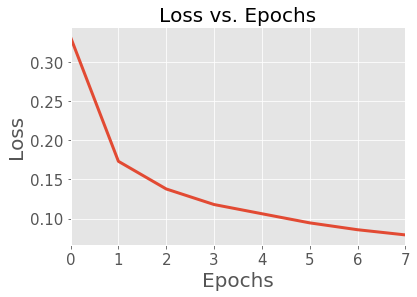

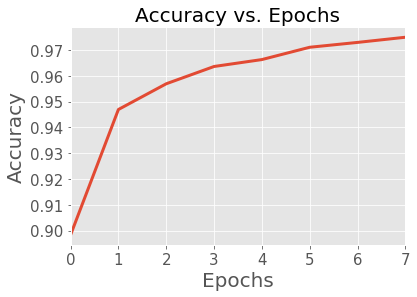

In [54]:
train_images = mnist.train_images() # Load training set
train_labels = mnist.train_labels() # Load training labels
train_images = (train_images / 255) *2-1 # Normalize between -1 and 1
train_images = train_images.reshape((-1,784)) # Flatten

model, history = nn.training(train_images, train_labels) # Train the neural network
plots.loss_acc_plots(history) # Plot loss and accuracy

test_labels = mnist.test_labels() # Load test labels
print("Validation of undamaged test set:")
test_loss, test_accuracy = model.evaluate(test_images, to_categorical(test_labels), 
                                          verbose=2) # Print test loss and acc

The accuracy for the test dataset is quite high: 97%. This accuracy drops as we include damage in the test images. For instance, with an intensity of 80% the accuracy is 55%. Can we recover the accuracy by firstly applying image inpainting?

## Image inpainting prior to classifying damaged images

Let's select a group of 5 images to add damage:

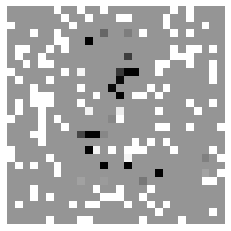

In [55]:
n_images = 5 # Number of images
indices_images = range(5) # Select indices
examples = test_images[indices_images,:].copy() # Choose examples from test set

intensity = 0.8 # Damage intensity
# damages = np.zeros((len(indices_images), int(examples.shape[1] * intensity)), dtype=int) # Instantiate damage matrices
# damaged_examples = examples.copy() # Instantiate damaged examples

damages = np.load("data/damages.npy") # Load a previously saved damage matrix

for i in range(len(indices_images)): # Loop over examples t introduce damage
#     damages[i, :] = np.random.choice(np.arange(examples.shape[1]), replace=False, 
#                                      size=int(examples.shape[1] * intensity)) # Choose random damage
    damaged_examples[i, damages[i, :]] = 0 # Turn damaged pixels to 0

plots.plot_image(damaged_examples[1,:]) # Plot one of the damaged examples

We proceed to restore those 5 images:

--------------------
Time:  0.0
['L1 norm of the difference between the new and old state: ', 227.90905061891908]
--------------------
Time:  0.1
['L1 norm of the difference between the new and old state: ', 92.73590898992742]
--------------------
Time:  0.2
['L1 norm of the difference between the new and old state: ', 54.91625640714811]
--------------------
Time:  0.30000000000000004
['L1 norm of the difference between the new and old state: ', 38.1183076633621]
--------------------
Time:  0.4
['L1 norm of the difference between the new and old state: ', 28.356995096230435]
--------------------
Time:  0.5
['L1 norm of the difference between the new and old state: ', 21.932264197866672]
--------------------
Time:  0.6
['L1 norm of the difference between the new and old state: ', 17.378866264948705]
--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 14.002056381181685]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference b

--------------------
Time:  0.7
['L1 norm of the difference between the new and old state: ', 13.423552151972892]
--------------------
Time:  0.7999999999999999
['L1 norm of the difference between the new and old state: ', 11.064805323142537]
--------------------
Time:  0.8999999999999999
['L1 norm of the difference between the new and old state: ', 9.212610011301475]
--------------------
Time:  0.9999999999999999
['L1 norm of the difference between the new and old state: ', 7.723088726354714]
--------------------
Time:  1.0999999999999999
['L1 norm of the difference between the new and old state: ', 6.514401157580582]
--------------------
Time:  1.2
['L1 norm of the difference between the new and old state: ', 12.327655164668284]
--------------------
Time:  1.3
['L1 norm of the difference between the new and old state: ', 9.77350814102571]
--------------------
Time:  1.4000000000000001
['L1 norm of the difference between the new and old state: ', 8.07661642169117]
--------------------

--------------------
Time:  1.3
['L1 norm of the difference between the new and old state: ', 4.760819736561235]
--------------------
Time:  1.4000000000000001
['L1 norm of the difference between the new and old state: ', 4.095796820671721]
--------------------
Time:  1.5000000000000002
['L1 norm of the difference between the new and old state: ', 3.606334926056597]
--------------------
Time:  1.6000000000000003
['L1 norm of the difference between the new and old state: ', 3.21997863125329]
--------------------
Time:  1.7000000000000004
['L1 norm of the difference between the new and old state: ', 2.893362891660514]
--------------------
Time:  1.8000000000000005
['L1 norm of the difference between the new and old state: ', 2.611204835584328]
--------------------
Time:  1.9000000000000006
['L1 norm of the difference between the new and old state: ', 2.37097360787899]
--------------------
Time:  2.0000000000000004
['L1 norm of the difference between the new and old state: ', 2.1609686144

--------------------
Time:  2.0000000000000004
['L1 norm of the difference between the new and old state: ', 3.1323609973570052]
--------------------
Time:  2.1000000000000005
['L1 norm of the difference between the new and old state: ', 2.7921674921435695]
--------------------
Time:  2.2000000000000006
['L1 norm of the difference between the new and old state: ', 2.5130799405228252]
--------------------
Time:  2.3000000000000007
['L1 norm of the difference between the new and old state: ', 2.2773831810618512]
--------------------
Time:  2.400000000000001
['L1 norm of the difference between the new and old state: ', 2.075038876463938]
--------------------
Time:  2.500000000000001
['L1 norm of the difference between the new and old state: ', 1.897834466508093]
--------------------
Time:  2.600000000000001
['L1 norm of the difference between the new and old state: ', 1.7451841528707153]
--------------------
Time:  2.700000000000001
['L1 norm of the difference between the new and old stat

--------------------
Time:  2.800000000000001
['L1 norm of the difference between the new and old state: ', 2.102465152938512]
--------------------
Time:  2.9000000000000012
['L1 norm of the difference between the new and old state: ', 1.9830905868355266]
--------------------
Time:  3.0000000000000013
['L1 norm of the difference between the new and old state: ', 1.8714540602566865]
--------------------
Time:  3.1000000000000014
['L1 norm of the difference between the new and old state: ', 1.7660119981409474]
--------------------
Time:  3.2000000000000015
['L1 norm of the difference between the new and old state: ', 1.6704985324637809]
--------------------
Time:  3.3000000000000016
['L1 norm of the difference between the new and old state: ', 1.5835967242120632]
--------------------
Time:  3.4000000000000017
['L1 norm of the difference between the new and old state: ', 1.5033561137378657]
--------------------
Time:  3.5000000000000018
['L1 norm of the difference between the new and old 

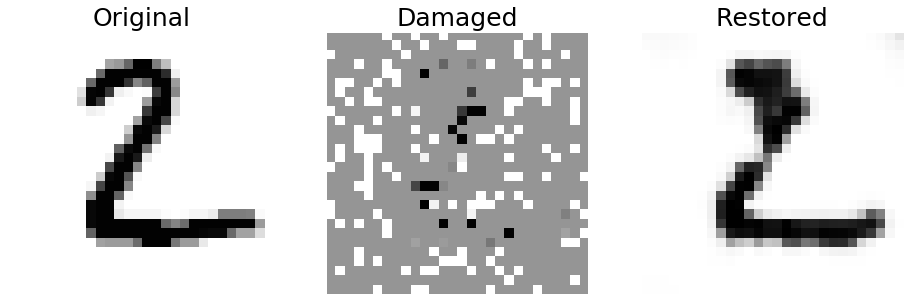

In [56]:
restored_examples = np.zeros(examples.shape) # Instantiate restored examples

for i in range(n_images): # Loop over damaged imaged
    restored_examples[i,:] = fvs.temporal_loop_split(
                                damaged_examples[i, :], damages[i, :])

plots.plot_3images(examples[1,:], damaged_examples[1,:], restored_examples[1,:])

We can now compare the ground truth with the predicted labels for the damaged and restore images:

In [57]:
predictions_damaged = np.argmax(model.predict(damaged_examples), axis=1)  
predictions_restored = np.argmax(model.predict(restored_examples), axis=1)    

print("Ground truth: ", test_labels[indices_images])
print("Damaged images: ", predictions_damaged)
print("Restored images: ", predictions_restored)

Ground truth:  [7 2 1 0 4]
Damaged images:  [7 2 3 0 4]
Restored images:  [7 2 1 0 4]


## Final remarks

The three take-home messages from this notebook are that:

1. Image inpainting can be solved with efficient and parallelizable finite-volume schemes
2. The classification accuracy of neural networks is affected by the presence of damage 
3. The application of image inpainting in damaged images improves their classification accuracy